# Network Traffic Forecasting (using time series data)

In telco, accurate forecast of KPIs (e.g. network traffic, utilizations, user experience, etc.) for communication networks ( 2G/3G/4G/5G/wired) can help predict network failures, allocate resource, or save energy. 

In this notebook, we demostrate a reference use case where we use the network traffic KPI(s) in the past to predict traffic KPI(s) in the future. We demostrate how to do **univariate forecasting** (predict only 1 series), and **multivariate forecasting** (predicts more than 1 series at the same time) using Project Zouwu.

For demonstration, we use the publicly available network traffic data repository maintained by the [WIDE project](http://mawi.wide.ad.jp/mawi/) and in particular, the network traffic traces aggregated every 2 hours (i.e. AverageRate in Mbps/Gbps and Total Bytes) in year 2018 and 2019 at the transit link of WIDE to the upstream ISP ([dataset link](http://mawi.wide.ad.jp/~agurim/dataset/)). 

## Helper functions

This section defines some helper functions to be used in the following procedures. You can refer to it later when they're used.

In [1]:
def get_drop_dates_and_len(df, allow_missing_num=3):
    """
    Find missing values and get records to drop
    """
    missing_num = df.total.isnull().astype(int).groupby(df.total.notnull().astype(int).cumsum()).sum()
    drop_missing_num = missing_num[missing_num > allow_missing_num]
    drop_datetimes = df.iloc[drop_missing_num.index].index
    drop_len = drop_missing_num.values
    return drop_datetimes, drop_len

In [2]:
def rm_missing_weeks(start_dts, missing_lens, df):
    """
    Drop weeks that contains more than 3 consecutive missing values.
    If consecutive missing values across weeks, we remove all the weeks.
    """ 
    for start_time, l in zip(start_dts, missing_lens):
        start = start_time - pd.Timedelta(days=start_time.dayofweek)
        start = start.replace(hour=0, minute=0, second=0)
        start_week_end = start + pd.Timedelta(days=6)
        start_week_end = start_week_end.replace(hour=22, minute=0, second=0)

        end_time = start_time + l*pd.Timedelta(hours=2)
        if start_week_end < end_time:
            end = end_time + pd.Timedelta(days=6-end_time.dayofweek)
            end = end.replace(hour=22, minute=0, second=0)
        else:
            end = start_week_end
        df = df.drop(df[start:end].index)
    return df

In [3]:
def gen_dataset_matrix(dataset, look_back, target_col_indexes):
    """
    Generate input samples from rolling
    """
    X, Y = [], []
    if len(target_col_indexes) == 1:
        del_col_index = {0, 1}.difference(set(target_col_indexes)).pop()
        data = np.delete(dataset, del_col_index, axis=1)
    else:
        data = dataset
    for i in range(len(data) - look_back):
        X.append(data[i: (i + look_back)])
        Y.append(data[i + look_back, target_col_indexes])
    return np.array(X), np.array(Y)

In [4]:
def unscale(scaler, y, target_col_indexes):
    """
    data needs to be normalized (scaled) before feeding into models. 
    This is to inverse the effect of normlization to get reasonable forecast results.
    """
    dummy_feature_shape = scaler.scale_.shape[0]
    y_dummy = np.zeros((y.shape[0], dummy_feature_shape))
    y_dummy[:, target_col_indexes] = y
    y_unscale = scaler.inverse_transform(y_dummy)[:,target_col_indexes]
    return y_unscale

In [5]:
EPSILON = 1e-10
def sMAPE(y_true, y_pred, multioutput="uniform_average"):
    """
    Symmetric Mean Average Percentage Error
    """
    if multioutput not in ["raw_values", "uniform_average"]:
        raise ValueError("multioutput must be 'raw_values' or 'uniform_average', got {}".format(multioutput))
    output_errors = np.mean(100 * np.abs(y_true - y_pred)/(np.abs(y_true) + np.abs(y_pred) + EPSILON), axis=0,)
    if multioutput == "raw_values":
        return output_errors
    return np.mean(output_errors)

In [6]:
def plot_predict_actual_values(date, y_pred, y_test, ylabel):
    """
    plot the predicted values and actual values (for the test data)
    """
    fig, axs = plt.subplots(figsize=(16,6))

    axs.plot(date, y_pred,color='red', label='predicted values')
    axs.plot(date, y_test,color='blue', label='actual values')
    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel('test datetime')
    plt.ylabel(ylabel)
    plt.legend(loc='upper left')
    plt.show()

## Download raw dataset and load into dataframe

Now we download the dataset and load it into a pandas dataframe. Steps are as below. 

* First, run the script `get_data.sh` to download the raw data. It will download the monthly aggregated traffic data in year 2018 and 2019 into `data` folder. The raw data contains aggregated network traffic (average MBPs and total bytes) as well as other metrics. 

* Second, run `extract_data.sh` to extract relavant traffic KPI's from raw data, i.e. `AvgRate` for average use rate, and `total` for total bytes. The script will extract the KPI's with timestamps into `data/data.csv`.

* Finally, use pandas to load `data/data.csv` into a dataframe as shown below

In [7]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
raw_df = pd.read_csv("data/data.csv")

Below are some example records of the data

In [9]:
raw_df.head()

,StartTime,EndTime,AvgRate,total
0,2018/01/01 00:00:00,2018/01/01 02:00:00,306.23Mbps,275605455598
1,2018/01/01 02:00:00,2018/01/01 04:00:00,285.03Mbps,256527692256
2,2018/01/01 04:00:00,2018/01/01 06:00:00,247.39Mbps,222652190823
3,2018/01/01 06:00:00,2018/01/01 08:00:00,211.55Mbps,190396029658
4,2018/01/01 08:00:00,2018/01/01 10:00:00,234.82Mbps,211340468977


## Data pre-processing

Now we need to do data cleaning and preprocessing on the raw data. Note that this part could vary for different dataset. 

For the network traffic data we're using, the processing contains 3 parts:
1. Convert string datetime to TimeStamp
2. Unify the measurement scale for `AvgRate` value - some uses Mbps, some uses Gbps 
3. Handle missing data (fill or drop).

In [10]:
df = pd.DataFrame(pd.to_datetime(raw_df.StartTime))

In [11]:
# we can find 'AvgRate' is of two scales: 'Mbps' and 'Gbps' 
raw_df.AvgRate.str[-4:].unique()

array(['Mbps', 'Gbps'], dtype=object)

In [12]:
# Unify AvgRate value
df['AvgRate'] = raw_df.AvgRate.apply(lambda x: float(x[:-4]) if x.endswith("Mbps") else float(x[:-4]) * 1000)

In [13]:
df["total"] = raw_df["total"]
df.set_index("StartTime", inplace=True)

In [14]:
df.head()

,AvgRate,total
StartTime,,
2018-01-01 00:00:00,306.23,275605455598
2018-01-01 02:00:00,285.03,256527692256
2018-01-01 04:00:00,247.39,222652190823
2018-01-01 06:00:00,211.55,190396029658
2018-01-01 08:00:00,234.82,211340468977


In [15]:
full_idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='2H')
df = df.reindex(full_idx)
print("no. of n/a values:")
print(df.isna().sum())

no. of n/a values:
AvgRate    3
total      3
dtype: int64


Here, we drop weeks with more than 3 consecutive missing values and fill other missing values remained.

In [16]:
drop_dts, drop_len = get_drop_dates_and_len(df)
df = rm_missing_weeks(drop_dts, drop_len, df)

In [17]:
df.ffill(inplace=True)

Plot the data to see how the KPI's look like

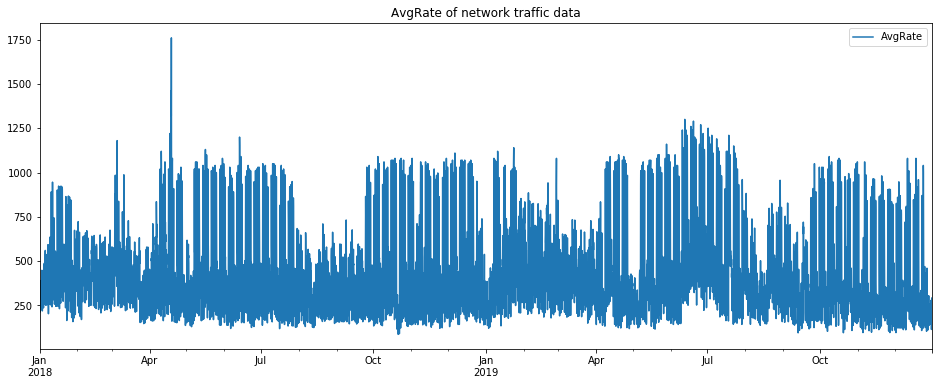

In [18]:
ax = df.plot(y='AvgRate',figsize=(16,6), title="AvgRate of network traffic data")

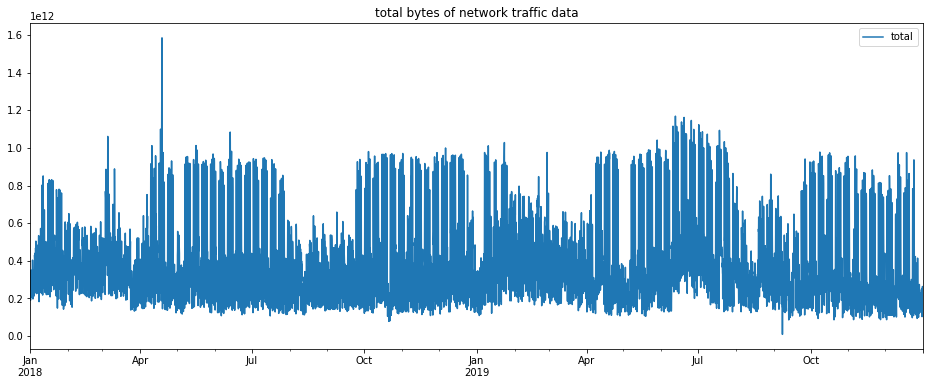

In [19]:
ax = df.plot(y='total',figsize=(16,6), title="total bytes of network traffic data")

## Feature Engineering

For feature engineering, we use year, month, week, day of week and hour as features in addition to the target KPI values

In [20]:
df["year"] = df.index.year
df["month"] = df.index.month
df["week"] = df.index.week
df["dayofweek"] = df.index.dayofweek
df["hour"] = df.index.hour

In [21]:
df.head()

,AvgRate,total,year,month,week,dayofweek,hour
2018-01-01 00:00:00,306.23,2.756055e+11,2018,1,1,0,0
2018-01-01 02:00:00,285.03,2.565277e+11,2018,1,1,0,2
2018-01-01 04:00:00,247.39,2.226522e+11,2018,1,1,0,4
2018-01-01 06:00:00,211.55,1.903960e+11,2018,1,1,0,6
2018-01-01 08:00:00,234.82,2.113405e+11,2018,1,1,0,8


## Data preparation

Now we split the dataset into train and test.

In [22]:
test_num = 1000
# we look back one week data which is of the frequency of 2h.
look_back = 84
test_split_index = test_num + look_back
target_dim = 1

#train_df
train_df = df[:-test_num]
test_df = df[-test_split_index:]
test_df = test_df.reset_index(drop=True)

Then standardize train, test data and featues

In [23]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
scaled_train = standard_scaler.fit_transform(train_df)
scaled_test = standard_scaler.transform(test_df)

Last, we generate model input samples by sliding window along time axis. Since univariant and multivariant forcasting uses different input data shape, we prepare data for each type of forcasting respectively.


* for _univariate_ forecasting, we forecast ``AvgRate`` only.

In [24]:
# for univeriate
# here we take "AvgRate" as an example
uni_target_col_indexes = [0]
uni_target_value = "AvgRate"

x_train, y_train = gen_dataset_matrix(scaled_train, look_back, uni_target_col_indexes)
x_test, y_test = gen_dataset_matrix(scaled_test, look_back, uni_target_col_indexes)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((7676, 84, 6), (7676, 1), (1000, 84, 6), (1000, 1))

* for _multivariate_ forecasting, we forecast `AvgRate` and `total` at the same time. 

In [25]:
# for multivariate
multi_target_col_indexes = [0, 1]
multi_target_value = ["AvgRate","total"]

x_train_m, y_train_m = gen_dataset_matrix(scaled_train, look_back, multi_target_col_indexes)
x_test_m, y_test_m = gen_dataset_matrix(scaled_test, look_back, multi_target_col_indexes)
x_train_m.shape, y_train_m.shape, x_test_m.shape, y_test_m.shape

((7676, 84, 7), (7676, 2), (1000, 84, 7), (1000, 2))

# Time series forecasting 

### Univariate forecasting

For univariate forcasting, we use LSTMForecaster for forecasting.

In [26]:
from zoo.zouwu.model.forecast import LSTMForecaster

W0426 11:05:07.672919 4458261952 module_wrapper.py:139] From /Users/yushan/sources/analytics-zoo/pyzoo/zoo/tfpark/zoo_optimizer.py:27: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



First we initiate a LSTMForecaster. 
* `feature_dim` should match the training data input feature, so we just use the last dimension of train data shape. 
* `target_dim` equals the variate num we want to predict. We set target_dim=1 for univariate forecasting.

In [27]:
# build model
lstm_config = {"lstm_1_units":32, "lstm_2_units":32, "lr":0.001}
forecaster = LSTMForecaster(target_dim=1, feature_dim=x_train.shape[-1], **lstm_config)

W0426 11:05:07.729089 4458261952 deprecation.py:506] From /Users/yushan/anaconda3/envs/automl/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Then we use fit to train the model. Wait sometime for it to finish.

In [28]:
%%time
forecaster.fit(x=x_train, y=y_train, batch_size=1024, epochs=50, distributed=False)

W0426 11:05:08.290032 4458261952 deprecation.py:323] From /Users/yushan/anaconda3/envs/automl/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0426 11:05:09.108528 4458261952 backend.py:548] OMP_NUM_THREADS is no longer used by the default Keras config. To configure the number of threads, use tf.config.threading APIs.


Train on 7676 samples
Epoch 1/50
7676/7676 [==============================] - 4s 512us/sample - loss: 0.9379 - mean_squared_error: 0.9379
Epoch 2/50
7676/7676 [==============================] - 3s 366us/sample - loss: 0.8336 - mean_squared_error: 0.8336
Epoch 3/50
7676/7676 [==============================] - 3s 349us/sample - loss: 0.7556 - mean_squared_error: 0.7556
Epoch 4/50
7676/7676 [==============================] - 3s 348us/sample - loss: 0.6553 - mean_squared_error: 0.6553
Epoch 5/50
7676/7676 [==============================] - 3s 356us/sample - loss: 0.5319 - mean_squared_error: 0.5319
Epoch 6/50
7676/7676 [==============================] - 3s 366us/sample - loss: 0.4112 - mean_squared_error: 0.4112
Epoch 7/50
7676/7676 [==============================] - 3s 366us/sample - loss: 0.3359 - mean_squared_error: 0.3359
Epoch 8/50
7676/7676 [==============================] - 3s 365us/sample - loss: 0.3031 - mean_squared_error: 0.3031
Epoch 9/50
7676/7676 [============================

After training is finished. You can use the forecaster to do prediction and evaluation.

In [29]:
# make prediction
y_pred = forecaster.predict(x_test)

Since we have used standard scaler to scale the input data (including the target values), we need to inverse the scaling on the predicted values too. 

In [30]:
y_pred_unscale = unscale(standard_scaler, y_pred, uni_target_col_indexes)
y_test_unscale = unscale(standard_scaler, y_test, uni_target_col_indexes)

calculate the symetric mean absolute percentage error.

In [31]:
# evaluate with sMAPE
print("sMAPE is", sMAPE(y_test_unscale, y_pred_unscale))
# evaluate with mean_squared_error
from sklearn.metrics import mean_squared_error
print("mean_squared error is", mean_squared_error(y_test_unscale, y_pred_unscale))

sMAPE is 8.441626722957785
mean_squared error is 5536.712494719992


### multivariate forecasting 

For multivariate forecasting, we use MTNetForecaster for forecasting. 

In [32]:
from zoo.zouwu.model.forecast import MTNetForecaster

First, we initialize a mtnet_forecaster according to input data shape. Specifcally, `look_back` should equal `(lb_long_steps+1)*lb_long_stepsize` .Details refer to [zouwu docs](https://github.com/intel-analytics/analytics-zoo/tree/master/pyzoo/zoo/zouwu).

In [33]:
mtnet_forecaster = MTNetForecaster(target_dim=y_train_m.shape[-1],
                        feature_dim=x_train_m.shape[-1],
                        lb_long_steps=6,
                        lb_long_stepsize=12,
                        ar_window_size=6,
                        cnn_kernel_size=4
    )

W0426 11:07:26.209068 4458261952 deprecation.py:506] From /Users/yushan/anaconda3/envs/automl/lib/python3.6/site-packages/tensorflow_core/python/keras/initializers.py:94: calling TruncatedNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
/Users/yushan/anaconda3/envs/automl/lib/python3.6/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


MTNet needs to preprocess the X into another format, so we call `MTNetForecaster.preprocess_input` on train_x and test_x.

In [34]:
# mtnet requires reshape of input x before feeding into model.
x_train_mtnet = mtnet_forecaster.preprocess_input(x_train_m)
x_test_mtnet = mtnet_forecaster.preprocess_input(x_test_m)

Now we train the model and wait till it finished. 

In [35]:
%%time
hist = mtnet_forecaster.fit(x = x_train_mtnet, y = y_train, batch_size=1024, epochs=20)

Train on 7676 samples
Epoch 1/20
7676/7676 [==============================] - 29s 4ms/sample - loss: 0.8927 - mean_squared_error: 1.2406
Epoch 2/20
7676/7676 [==============================] - 16s 2ms/sample - loss: 0.7957 - mean_squared_error: 1.0574
Epoch 3/20
7676/7676 [==============================] - 16s 2ms/sample - loss: 0.7176 - mean_squared_error: 0.9697
Epoch 4/20
7676/7676 [==============================] - 16s 2ms/sample - loss: 0.6583 - mean_squared_error: 0.8638
Epoch 5/20
7676/7676 [==============================] - 16s 2ms/sample - loss: 0.6067 - mean_squared_error: 0.7385
Epoch 6/20
7676/7676 [==============================] - 27s 4ms/sample - loss: 0.5578 - mean_squared_error: 0.6528
Epoch 7/20
7676/7676 [==============================] - 20s 3ms/sample - loss: 0.5170 - mean_squared_error: 0.5675
Epoch 8/20
7676/7676 [==============================] - 17s 2ms/sample - loss: 0.4802 - mean_squared_error: 0.4850
Epoch 9/20
7676/7676 [==============================] - 18

Use the model for prediction and inverse the scaling of the prediction results

In [36]:
y_pred_m = mtnet_forecaster.predict(x_test_mtnet)

In [37]:
y_pred_m_unscale = unscale(standard_scaler, y_pred_m, multi_target_col_indexes)
y_test_m_unscale = unscale(standard_scaler, y_test_m, multi_target_col_indexes)

In [38]:
# evaluate with sMAPE
print("sMAPE is",sMAPE(y_pred_m_unscale, y_test_m_unscale, multioutput="raw_values"))
# evaluate with mean_squared_error
print("mean squared error is", mean_squared_error(y_test_m_unscale, y_pred_m_unscale, multioutput="raw_values"))

sMAPE is [10.91735154  9.66272596]
mean squared error is [9.52242322e+03 5.49956707e+21]


plot actual and prediction values for `AvgRate` KPI

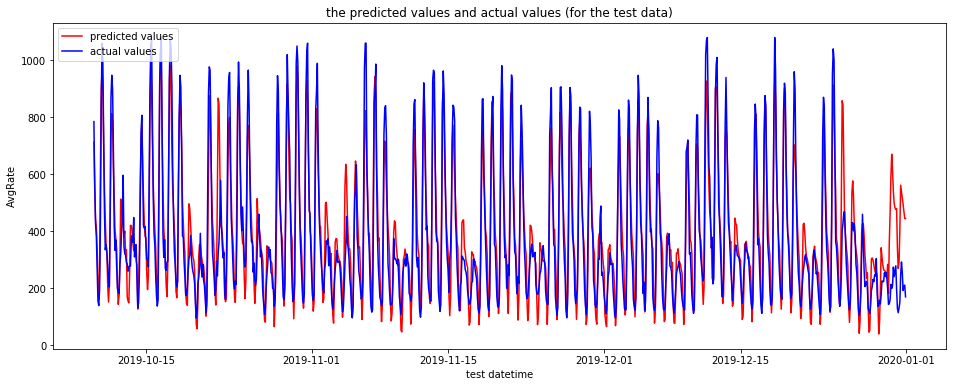

In [40]:
test_date=df[-test_num:].index
plot_predict_actual_values(test_date, y_pred_m_unscale[:,0], y_test_m_unscale[:,0], ylabel=multi_target_value[0])

plot actual and prediction values for `total bytes` KPI

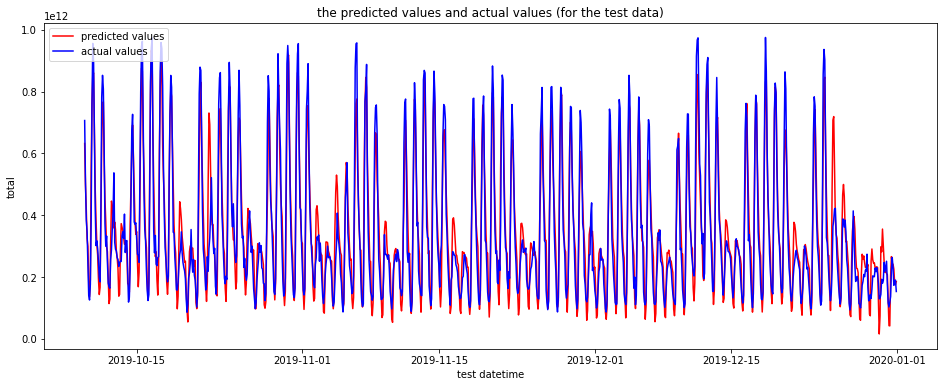

In [41]:
plot_predict_actual_values(test_date, y_pred_m_unscale[:,1], y_test_m_unscale[:,1], ylabel=multi_target_value[1])